# Job Search with Separation

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

This module solves for the optimal policy of an agent who can be either
unemployed or employed. The key features of the model are:

## Model Setup

- Agent receives wage offers w from a finite set when unemployed
- Wage offers follow a Markov chain with transition matrix P
- Jobs terminate with probability α each period (separation rate)
- Unemployed workers receive compensation c per period
- Future payoffs discounted by factor β ∈ (0,1)

## Decision Problem

When unemployed and receiving wage offer w, the agent chooses between:
1. Accept offer w: Become employed at wage w
2. Reject offer: Remain unemployed, receive c, get new offer next period

## Value Functions

- v_u*(w): Value of being unemployed when current wage offer is w
- v_e*(w): Value of being employed at wage w

## Bellman Equations

The unemployed worker's value function satisfies:

$$v_u^*(w) = \max\{v_e^*(w), c + \beta \sum_{w'} v_u^*(w') P(w,w')\}$$

The employed worker's value function satisfies:

$$v_e^*(w) = w + \beta[\alpha \sum_{w'} v_u^*(w') P(w,w') + (1-\alpha) v_e^*(w)]$$

## Computational Approach

1. Solve the employed value function analytically:
   $$v_e^*(w) = \frac{1}{1-\beta(1-\alpha)} \cdot (w + \alpha\beta(Pv_u^*)(w))$$

2. Substitute into unemployed Bellman equation to get:
   $$v_u^*(w) = \max\left\{\frac{1}{1-\beta(1-\alpha)} \cdot (w + \alpha\beta(Pv_u^*)(w)), c + \beta(Pv_u^*)(w)\right\}$$

3. Use value function iteration to solve for v_u*
4. Compute optimal policy: accept if v_e*(w) ≥ c + β(Pv_u*)(w)

The optimal policy is a reservation wage strategy: accept all wages above
some threshold w*.

## Code

In addition to what's in Anaconda, this lecture will need the QE library:

In [1]:
#!pip install quantecon  # Uncomment if necessary

We use the following imports:

In [2]:
from quantecon.markov import tauchen
import jax.numpy as jnp
import jax
from jax import jit, lax
from typing import NamedTuple
import matplotlib.pyplot as plt
from functools import partial

First, we implement the successive approximation algorithm:

In [3]:
@partial(jit, static_argnums=(0,))
def successive_approx(
        T,                         # Operator (callable) - marked as static
        x_0,                       # Initial condition
        tolerance: float = 1e-6,   # Error tolerance
        max_iter: int = 100_000,   # Max iteration bound
    ):
    """Computes the approximate fixed point of T via successive
    approximation using lax.while_loop."""
    
    def cond_fn(carry):
        x, error, k = carry
        return (error > tolerance) & (k <= max_iter)
    
    def body_fn(carry):
        x, error, k = carry
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        return (x_new, error, k + 1)
    
    initial_carry = (x_0, tolerance + 1, 1)
    x_final, _, _ = lax.while_loop(cond_fn, body_fn, initial_carry)
    
    return x_final

Let's set up a `Model` class to store information needed to solve the model:

In [4]:
class Model(NamedTuple):
    n: int
    w_vals: jnp.ndarray
    P: jnp.ndarray
    β: float
    c: float
    α: float

The function below holds default values and creates a `Model` instance:

In [5]:
def create_js_with_sep_model(
        n: int = 200,          # wage grid size
        ρ: float = 0.9,        # wage persistence
        ν: float = 0.2,        # wage volatility
        β: float = 0.96,       # discount factor
        α: float = 0.05,       # separation rate
        c: float = 1.0         # unemployment compensation
    ) -> Model:
    """Creates an instance of the job search model with separation."""
    mc = tauchen(n, ρ, ν)
    w_vals, P = jnp.exp(jnp.array(mc.state_values)), jnp.array(mc.P)
    return Model(n, w_vals, P, β, c, α)

Here's the Bellman operator for the unemployed worker's value function:

In [6]:
@jit
def T(v: jnp.ndarray, model: Model) -> jnp.ndarray:
    """The Bellman operator for the value of being unemployed."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P @ v)
    reject = c + β * P @ v
    return jnp.maximum(accept, reject)

The next function computes the optimal policy under the assumption that v is
the value function:

In [7]:
@jit
def get_greedy(v: jnp.ndarray, model: Model) -> jnp.ndarray:
    """Get a v-greedy policy."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P @ v)
    reject = c + β * P @ v
    σ = accept >= reject
    return σ

Here's a routine for value function iteration:

In [8]:
def vfi(model: Model):
    """Solve by VFI."""
    v_init = jnp.zeros(model.w_vals.shape)
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

def get_reservation_wage(σ: jnp.ndarray, model: Model) -> float:
    """
    Calculate the reservation wage from a given policy.

    Parameters:
    - σ: Policy array where σ[i] = True means accept wage w_vals[i]
    - model: Model instance containing wage values

    Returns:
    - Reservation wage (lowest wage for which policy indicates acceptance)
    """
    n, w_vals, P, β, c, α = model

    # Find all wage indices where policy indicates acceptance
    accept_indices = jnp.where(σ == 1)[0]

    if len(accept_indices) == 0:
        return jnp.inf  # Agent never accepts any wage

    # Return the lowest wage that is accepted
    return w_vals[accept_indices[0]]

## Computing the Solution

Let's solve the model and plot the results:

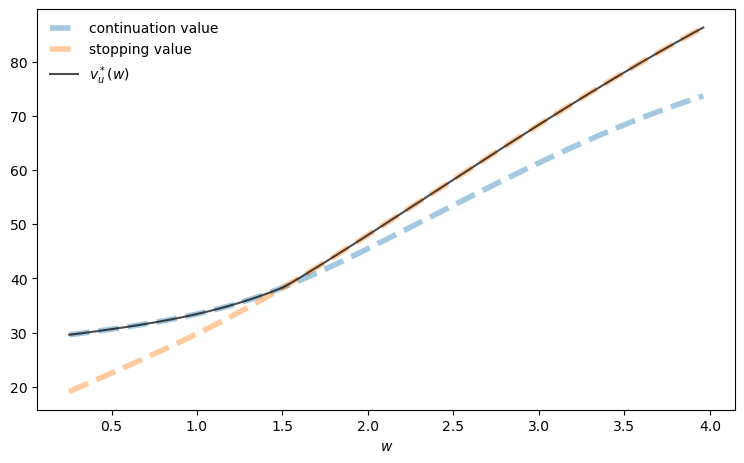

In [9]:
model = create_js_with_sep_model()
n, w_vals, P, β, c, α = model
v_star, σ_star = vfi(model)

d = 1 / (1 - β * (1 - α))
accept = d * (w_vals + α * β * P @ v_star)
h_star = c + β * P @ v_star

w_star = get_reservation_wage(σ_star, model)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4,
        label="continuation value")
ax.plot(w_vals, accept, linewidth=4, ls="--", alpha=0.4,
        label="stopping value")
ax.plot(w_vals, v_star, "k-", alpha=0.7, label=r"$v_u^*(w)$")
ax.legend(frameon=False)
ax.set_xlabel(r"$w$")
plt.show()

## Sensitivity Analysis

Let's examine how reservation wages change with the separation rate α:

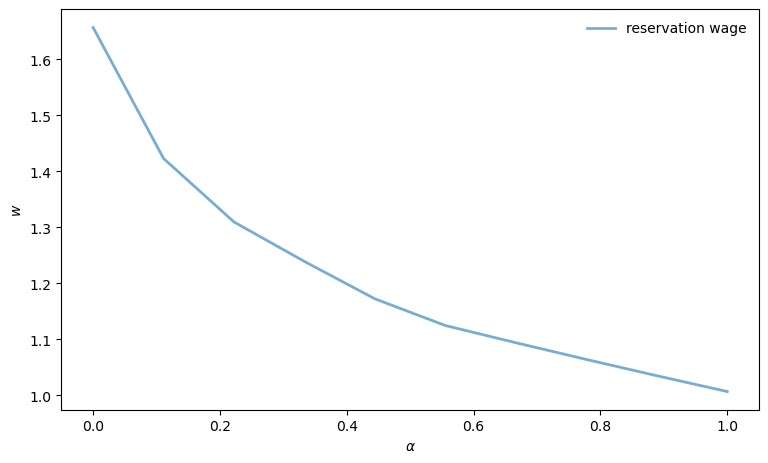

In [10]:
α_vals: jnp.ndarray = jnp.linspace(0.0, 1.0, 10)

w_star_vec = jnp.empty_like(α_vals)
for (i_α, α) in enumerate(α_vals):
    model = create_js_with_sep_model(α=α)
    v_star, σ_star = vfi(model)
    w_star = get_reservation_wage(σ_star, model)
    w_star_vec = w_star_vec.at[i_α].set(w_star)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(α_vals, w_star_vec, linewidth=2, alpha=0.6,
        label="reservation wage")
ax.legend(frameon=False)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$w$")
plt.show()

## Employment Simulation

Now let's simulate the employment dynamics of a single agent under the optimal policy:

In [11]:
@jit
def weighted_choice(key, probs):
    """JAX-compatible weighted random choice."""
    cumsum = jnp.cumsum(probs)
    return jnp.searchsorted(cumsum, jax.random.uniform(key))

@jit
def update_agent(key, is_employed, wage_idx, model, σ_star):
    n, w_vals, P, β, c, α = model
    
    key1, key2 = jax.random.split(key)
    new_wage_idx = weighted_choice(key1, P[wage_idx, :])
    separation_occurs = jax.random.uniform(key2) < α
    accepts = σ_star[wage_idx]
    
    # If employed: status = 1 if no separation, 0 if separation
    # If unemployed: status = 1 if accepts, 0 if rejects
    final_employment = jnp.where(
        is_employed,
        1 - separation_occurs.astype(jnp.int32),  # employed path
        accepts.astype(jnp.int32)                 # unemployed path
    )
    
    # If employed: wage = current if no separation, new if separation
    # If unemployed: wage = current if accepts, new if rejects
    final_wage = jnp.where(
        is_employed,
        jnp.where(separation_occurs, new_wage_idx, wage_idx),  # employed path
        jnp.where(accepts, wage_idx, new_wage_idx)             # unemployed path
    )

    return final_employment, final_wage

In [12]:
def simulate_employment_path(
        model: Model,     # Model details
        T: int = 2_000,   # Simulation length
        seed: int = 42    # Set seed for simulation
    ):
    """
    Simulate employment path for T periods starting from unemployment.

    """
    key = jax.random.PRNGKey(seed)
    # Unpack, solve for optimal policy
    n, w_vals, P, β, c, α = model
    v_star, σ_star = vfi(model)

    # Start unemployed with uniform wage draw
    key, subkey = jax.random.split(key)
    is_employed = 0
    wage_idx = jax.random.randint(subkey, (), 0, n)

    wage_path_list = []
    employment_status_list = []

    for t in range(T):
        wage_path_list.append(w_vals[wage_idx])
        employment_status_list.append(is_employed)
        
        key, subkey = jax.random.split(key)
        is_employed, wage_idx = update_agent(
            subkey, is_employed, wage_idx, model, σ_star
        )

    return jnp.array(wage_path_list), jnp.array(employment_status_list)

Let's create a comprehensive plot of the employment simulation:

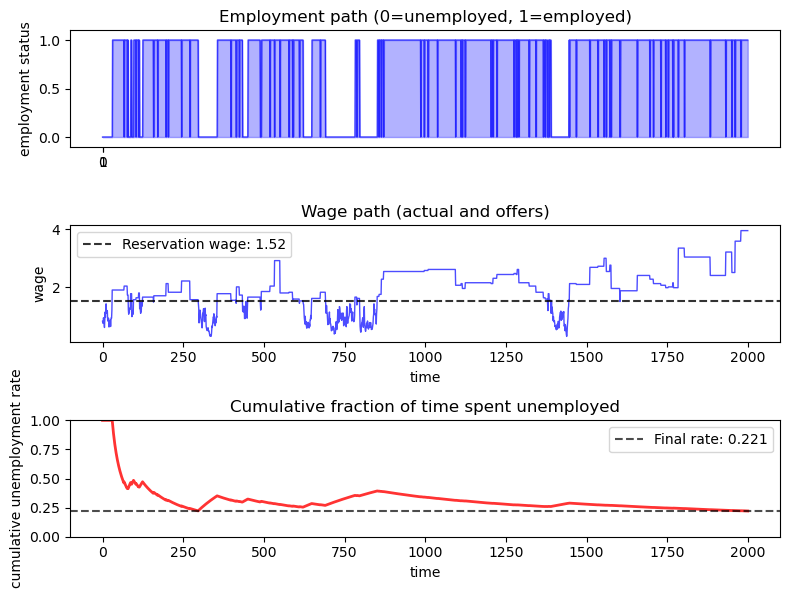

In [13]:
model = create_js_with_sep_model()

# Calculate reservation wage for plotting
v_star, σ_star = vfi(model)
w_star = get_reservation_wage(σ_star, model)

wage_path, employment_status = simulate_employment_path(model)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

# Plot employment status
ax1.plot(employment_status, 'b-', alpha=0.7, linewidth=1)
ax1.fill_between(
    range(len(employment_status)), employment_status, alpha=0.3, color='blue'
)
ax1.set_ylabel('employment status')
ax1.set_title('Employment path (0=unemployed, 1=employed)')
ax1.set_xticks((0, 1))
ax1.set_ylim(-0.1, 1.1)

# Plot wage path with employment status coloring
ax2.plot(wage_path, 'b-', alpha=0.7, linewidth=1)
ax2.axhline(y=w_star, color='black', linestyle='--', alpha=0.8,
           label=f'Reservation wage: {w_star:.2f}')
ax2.set_xlabel('time')
ax2.set_ylabel('wage')
ax2.set_title('Wage path (actual and offers)')
ax2.legend()

# Plot cumulative fraction of time unemployed
unemployed_indicator = (employment_status == 0).astype(int)
cumulative_unemployment = (
    jnp.cumsum(unemployed_indicator) /
    jnp.arange(1, len(employment_status) + 1)
)

ax3.plot(cumulative_unemployment, 'r-', alpha=0.8, linewidth=2)
ax3.axhline(y=jnp.mean(unemployed_indicator), color='black',
            linestyle='--', alpha=0.7,
            label=f'Final rate: {jnp.mean(unemployed_indicator):.3f}')
ax3.set_xlabel('time')
ax3.set_ylabel('cumulative unemployment rate')
ax3.set_title('Cumulative fraction of time spent unemployed')
ax3.legend()
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Results Summary

The simulation demonstrates the model's key predictions:

1. **Optimal Policy**: The agent follows a reservation wage strategy
2. **Employment Dynamics**: Realistic patterns of job search, acceptance, and separation
3. **Steady State**: The cumulative unemployment rate converges to the theoretical prediction
4. **Labor Market Flows**: Clear cycles between unemployment and employment spells

The model successfully captures the essential features of labor market dynamics with job separation, showing how workers optimally balance the trade-off between accepting current offers versus waiting for better opportunities.

## Cross-Sectional Analysis

Now let's simulate many agents simultaneously to examine the cross-sectional unemployment rate:

In [14]:
# Create vectorized version of update_agent
update_agents_vmap = jax.vmap(update_agent, in_axes=(0, 0, 0, None, None))

In [15]:
@partial(jit, static_argnums=(3, 4))
def _simulate_cross_section_compiled(key, model, σ_star, n_agents, T):
    """JIT-compiled core simulation loop using lax.scan."""
    n, w_vals, P, β, c, α = model
    
    # Initialize arrays
    key, subkey = jax.random.split(key)
    wage_indices = jax.random.randint(subkey, (n_agents,), 0, n)
    is_employed = jnp.zeros(n_agents, dtype=jnp.int32)
    
    def scan_fn(carry, t):
        key, is_employed, wage_indices = carry
        
        # Record employment status for this time step 
        employment_status = is_employed
        
        key, *agent_keys = jax.random.split(key, n_agents + 1)
        agent_keys = jnp.array(agent_keys)
        
        is_employed, wage_indices = update_agents_vmap(
            agent_keys, is_employed, wage_indices, model, σ_star
        )
        
        return (key, is_employed, wage_indices), employment_status
    
    # Run simulation using scan
    initial_carry = (key, is_employed, wage_indices)
    _, employment_matrix = lax.scan(scan_fn, initial_carry, jnp.arange(T))
    
    # Transpose to get (n_agents, T) shape
    employment_matrix = employment_matrix.T
    
    return employment_matrix


def simulate_cross_section(
        model: Model,
        n_agents: int = 100_000,
        T: int = 200,
        seed: int = 42
    ) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Simulate employment paths for many agents simultaneously.

    Parameters:
    - model: Model instance with parameters
    - n_agents: Number of agents to simulate
    - T: Number of periods to simulate
    - seed: Random seed for reproducibility

    Returns:
    - unemployment_rates: Fraction of agents unemployed at each period
    - employment_matrix: n_agents x T matrix of employment status
    """
    key = jax.random.PRNGKey(seed)

    # Solve for optimal policy
    v_star, σ_star = vfi(model)
    
    # Run JIT-compiled simulation
    employment_matrix = _simulate_cross_section_compiled(key, model, σ_star, n_agents, T)
    
    # Calculate unemployment rate at each period
    unemployment_rates = 1 - jnp.mean(employment_matrix, axis=0)

    return unemployment_rates, employment_matrix

In [16]:
def plot_cross_sectional_unemployment(model: Model):
    """
    Generate cross-sectional unemployment rate plot for a given model.

    Parameters:
    - model: Model instance with parameters
    """
    unemployment_rates, employment_matrix = simulate_cross_section(model)

    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot unemployment rate over time
    ax.plot(unemployment_rates, 'b-', alpha=0.8, linewidth=1.5,
            label=f'Cross-sectional unemployment rate (c={model.c})')

    # Add shaded region for ±1 standard deviation
    window_size = 50
    rolling_std = jnp.array([
        jnp.std(unemployment_rates[max(0, t-window_size):t+1])
        for t in range(len(unemployment_rates))
    ])

    ax.fill_between(range(len(unemployment_rates)),
                    unemployment_rates - rolling_std,
                    unemployment_rates + rolling_std,
                    alpha=0.2, color='blue',
                    label='±1 rolling std')

    ax.set_xlabel('time')
    ax.set_ylabel('unemployment rate')
    ax.set_title(f'Cross-sectional unemployment rate (c={model.c})')
    ax.grid(alpha=0.4)
    ax.set_ylim(0, 1)
    ax.legend()

    plt.tight_layout()
    plt.show()

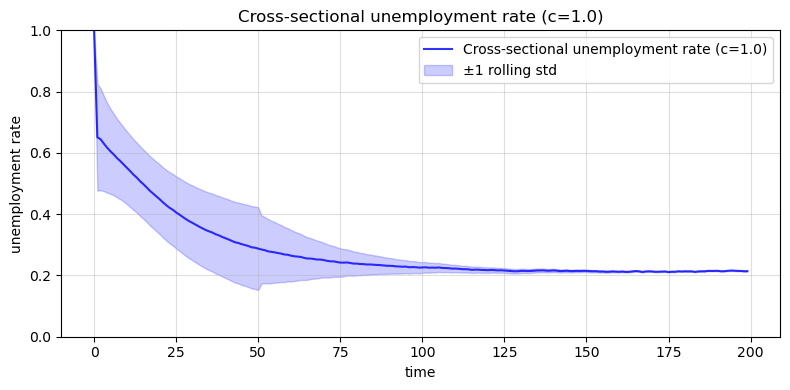

In [17]:
model = create_js_with_sep_model()
plot_cross_sectional_unemployment(model)

## Cross-Sectional Analysis with Lower Unemployment Compensation (c=0.5)

Let's examine how the cross-sectional unemployment rate changes with lower unemployment compensation:

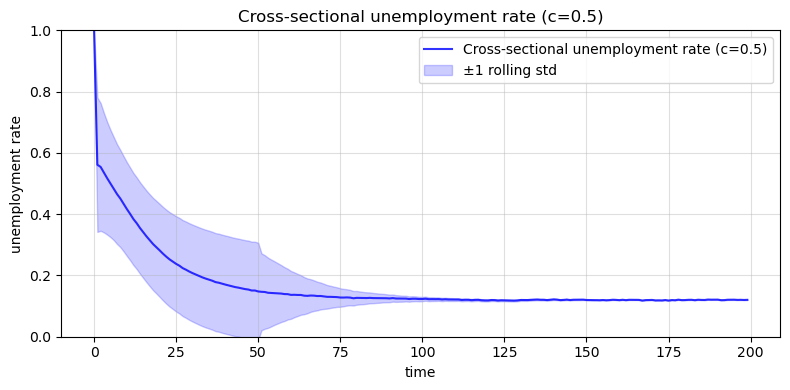

In [18]:
model_low_c = create_js_with_sep_model(c=0.5)
plot_cross_sectional_unemployment(model_low_c)

## Exercise

Create a plot that shows how the steady state cross-sectional unemployment rate
changes with unemployment compensation.

In [19]:
for _ in range(20):
    print('Solution below!')

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


## Solution

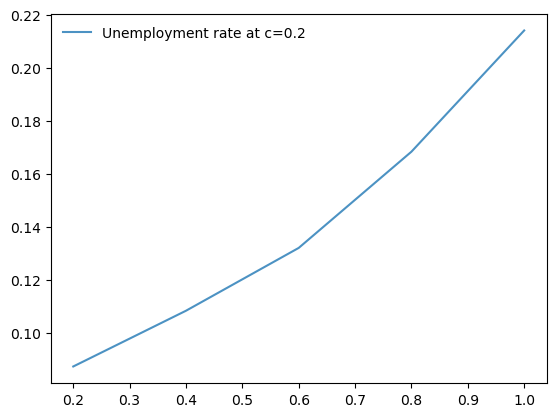

In [20]:
c_values = 1.0, 0.8, 0.6, 0.4, 0.2
rates = []
for c in c_values:
    model = create_js_with_sep_model(c=c)
    unemployment_rates, employment_matrix = simulate_cross_section(model)
    rates.append(unemployment_rates[-1])

fig, ax = plt.subplots()
ax.plot(
    c_values, rates, alpha=0.8, 
    linewidth=1.5, label=f'Unemployment rate at c={c}'
)
ax.legend(frameon=False)
plt.show()